In [1]:
# # PV Empirical MPP Model, by Alejo Perdomo
# 
# Empirical panel model (for V < Voc):
#   I(V) = 0.5 * I_sc * (G/1000) * ( 1 + (V - Voc + 1)/(V - Voc - 1) )
#   P(V) = V * I(V)
# MPP is obtained by solving dP/dV = 0.

# %%
import sympy as sym

# Reuse your function/time symbols
d = sym.Derivative
f = sym.Function
t = sym.symbols("t", constant=False)

# Irradiance is already defined as:
pv_g = f(r"g_{PV}", real=True, positive=True)(t)

# PV parameters for the empirical model
pv_v_oc, pv_i_sc = sym.symbols(
    r"V_{PV\,OC\,NOCT} I_{PV\,SC\,NOCT}", real=True, positive=True
)

# MPP outputs as time functions
pv_v_mpp = f(r"v_{PV,MPP}", real=True, positive=True)(t)
pv_i_mpp = f(r"i_{PV,MPP}", real=True, positive=True)(t)

# Local voltage variable for calculus
V = sym.symbols("V", real=True)

# Empirical I-V model (symbolic) in your naming:
# I(V) = 0.5 * pv_i_sc * (pv_g/1000) * ( 1 + (V - pv_v_oc + 1)/(V - pv_v_oc - 1) )
eq_pv_I = sym.Eq(
    f(r"i_{PV}", real=True)(V),
    (1/2) * pv_i_sc * (pv_g / 1000.0) *
    (1.0 + (V - pv_v_oc + 1.0) / (V - pv_v_oc - 1.0))
)
display(eq_pv_I)

Ipv_expr = sym.simplify(eq_pv_I.rhs)

# Power: P(V) = V * I(V)
P_expr = sym.simplify(V * Ipv_expr)

# Condition for MPP: dP/dV = 0
dP_dV = sym.simplify(sym.diff(P_expr, V))

# Solve for V (may return multiple roots; we select the one in (0, Voc))
V_solutions = sym.solve(sym.Eq(dP_dV, 0), V)

# [ASSUMPTION]: The physically relevant solution is the one in (0, pv_v_oc),
# which for this model corresponds to:
V_mpp_expr = sym.simplify(V_solutions[0])

# Current at MPP: I_mpp = I(V_mpp)
I_mpp_expr = sym.simplify(Ipv_expr.subs(V, V_mpp_expr))

# Link to your time-domain MPP functions
eq_pv_v_mpp = sym.Eq(pv_v_mpp, V_mpp_expr)
eq_pv_i_mpp = sym.Eq(pv_i_mpp, I_mpp_expr)

display(eq_pv_v_mpp)
display(eq_pv_i_mpp)
print(sym.latex(eq_pv_v_mpp))
print(sym.latex(eq_pv_i_mpp))

# Numeric helpers -------------------------------------------------------------
# [ASSUMPTION]: For numeric evaluation we treat pv_g(t) as a scalar G >= 0.
G = sym.symbols("G", real=True, nonnegative=True)
I_mpp_expr_G = sym.simplify(I_mpp_expr.subs(pv_g, G))

pv_v_mpp_fn = sym.lambdify((pv_v_oc,), V_mpp_expr, "numpy")
pv_i_mpp_fn = sym.lambdify((pv_v_oc, pv_i_sc, G), I_mpp_expr_G, "numpy")


Eq(i_{PV}(V), 0.0005*I_{PV,SC,NOCT}*(1.0 + (V - V_{PV,OC,NOCT} + 1.0)/(V - V_{PV,OC,NOCT} - 1.0))*g_{PV}(t))

Eq(v_{PV,MPP}(t), V_{PV,OC,NOCT} - sqrt(V_{PV,OC,NOCT} + 1.0) + 1.0)

Eq(i_{PV,MPP}(t), 0.001*I_{PV,SC,NOCT}*g_{PV}(t) - 0.001*I_{PV,SC,NOCT}*g_{PV}(t)/sqrt(V_{PV,OC,NOCT} + 1.0))

v_{PV,MPP}{\left(t \right)} = V_{PV,OC,NOCT} - \sqrt{V_{PV,OC,NOCT} + 1.0} + 1.0
i_{PV,MPP}{\left(t \right)} = 0.001 I_{PV,SC,NOCT} g_{PV}{\left(t \right)} - \frac{0.001 I_{PV,SC,NOCT} g_{PV}{\left(t \right)}}{\sqrt{V_{PV,OC,NOCT} + 1.0}}


In [2]:
import inspect

print(inspect.getsource(pv_v_mpp_fn))
print(inspect.getsource(pv_i_mpp_fn))

def _lambdifygenerated(Dummy_47):
    return Dummy_47 - sqrt(Dummy_47 + 1.0) + 1.0

def _lambdifygenerated(Dummy_48, Dummy_49, G):
    return 0.001*Dummy_49*G - 0.001*Dummy_49*G/sqrt(Dummy_48 + 1.0)



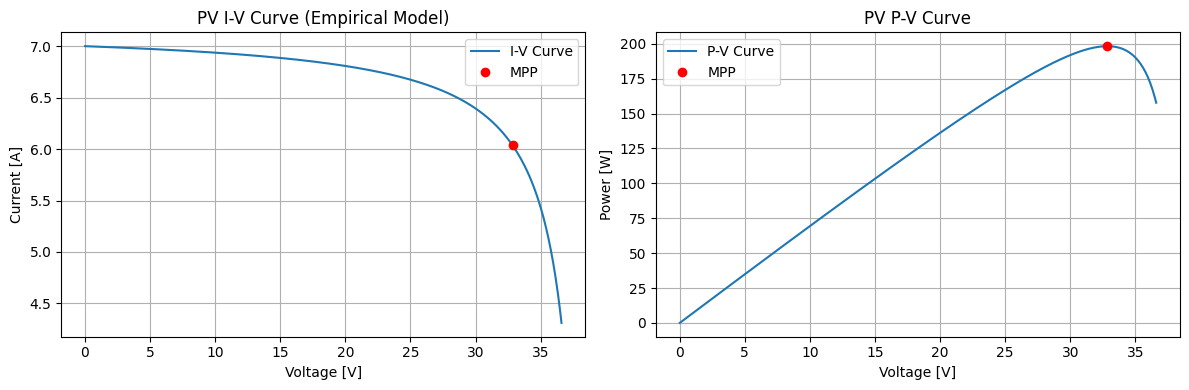

In [6]:
# %% [markdown]
# # Plot PV I-V and P-V curves (Empirical Model)

import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

# Convert to numeric function
Ipv_expr_G = sym.simplify(Ipv_expr.subs(pv_g, G))
Ipv_fn = sym.lambdify((V, pv_v_oc, pv_i_sc, G), Ipv_expr_G, "numpy")


# MPP expressions derived earlier:
V_mpp_expr = pv_v_oc - sym.sqrt(pv_v_oc + 1) + 1
I_mpp_expr = pv_i_sc * (G/1000) * (1 - 1/sym.sqrt(pv_v_oc + 1))

V_mpp_fn = sym.lambdify((pv_v_oc,), V_mpp_expr, "numpy")
I_mpp_fn = sym.lambdify((pv_v_oc, pv_i_sc, G), I_mpp_expr, "numpy")

# --------------------------------------------------------------------------
# Choose numeric values for demonstration
Voc_val = 38.1    # open-circuit voltage [V]
Isc_val = 8.98    # short-circuit current at 1000 W/m² [A]
G_val   = 800.0  # irradiance [W/m²]

# Voltage sweep (avoid singular point V = Voc - 1)
V_vals = np.linspace(0.01, Voc_val - 1.5, 400)

# Evaluate I(V)
I_vals = Ipv_fn(V_vals, Voc_val, Isc_val, G_val)
I_vals = np.maximum(I_vals, 0)  # clamp negatives

# Power
P_vals = V_vals * I_vals

# MPP numeric
V_mpp = V_mpp_fn(Voc_val)
I_mpp = I_mpp_fn(Voc_val, Isc_val, G_val)
P_mpp = V_mpp * I_mpp

# --------------------------------------------------------------------------
# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# I-V curve
ax[0].plot(V_vals, I_vals, label="I-V Curve")
ax[0].plot(V_mpp, I_mpp, "ro", label="MPP")

ax[0].set_title("PV I-V Curve (Empirical Model)")
ax[0].set_xlabel("Voltage [V]")
ax[0].set_ylabel("Current [A]")
ax[0].grid(True)
ax[0].legend()

# P-V curve
ax[1].plot(V_vals, P_vals, label="P-V Curve")
ax[1].plot(V_mpp, P_mpp, "ro", label="MPP")

ax[1].set_title("PV P-V Curve")
ax[1].set_xlabel("Voltage [V]")
ax[1].set_ylabel("Power [W]")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()
